ADIM 1: Veriyi Yükleme ve İlk Bakış
"Veri seti ilk yüklendiğinde Fiyat ve Yorum Sayısı sütunlarının 'object' (metin) tipinde olduğu görüldü. Model eğitimi için bunların sayısal (float/int) tipe dönüştürülmesi gerekmektedir."

In [1]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme Ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# 1. Veriyi Yükle (BİRLEŞTİRİLMİŞ DOSYA)
try:
    df = pd.read_csv("tum_urunler_tam.csv")
    print(f"✅ Veri Seti Başarıyla Yüklendi!")
    print(f"   -> Toplam Ham Veri Sayısı: {len(df)}")
except FileNotFoundError:
    print("❌ Hata: 'tum_urunler_tam.csv' bulunamadı. Lütfen merge_data.py'yi çalıştırın.")

# --- FİLTRELEME: Tablet Kategorisini Çıkar (Veri Azlığı Nedeniyle) ---
if 'Kategori' in df.columns:
    tablet_sayisi = len(df[df['Kategori'] == 'Tablet'])
    print(f"   -> Tablet Sayısı: {tablet_sayisi} (Çıkarılıyor...)")
    
    df = df[df['Kategori'] != 'Tablet']
    print(f"✅ Filtreleme Sonrası Veri Sayısı: {len(df)}")

# 2. Veriye İlk Bakış
print("\n--- İlk 5 Satır ---")
display(df.head())

print("\n--- Veri Özeti ---")
print(df.info())

✅ Veri Seti Başarıyla Yüklendi!
   -> Toplam Ham Veri Sayısı: 7000
   -> Tablet Sayısı: 10 (Çıkarılıyor...)
✅ Filtreleme Sonrası Veri Sayısı: 6990

--- İlk 5 Satır ---


,Kategori,Marka,Model,Fiyat,Yorum_Sayisi,Link
0,Televizyon,Onvo,"Onvo 75OVF9001UQ Ultra HD 75"" Uydu Alıcılı Goo...",3275695,3.0,https://www.n11.com/urun/onvo-75ovf9001uq-ultr...
1,Televizyon,ONVO,"ONVO 43OVF9000FQ 43 ""109 Ekran Uydu Alıcılı Sm...",107250,0.0,https://www.n11.com/urun/onvo-43ovf9000fq-43-1...
2,Televizyon,Onvo,"Onvo 55OVF9250UQ 55"" Uydu Alıcılı 4K Ultra HD ...",172114,15.0,https://www.n11.com/urun/onvo-55ovf9250uq-55-u...
3,Televizyon,Onvo,"Onvo 65OVF9250UQ 65"" Ultra HD 4K TV",221990,4.0,https://www.n11.com/urun/onvo-65ovf9250uq-65-u...
4,Televizyon,Onvo,"Onvo 50OVF9001UQ 50"" 127 Ekran 4K Ultra HD Uyd...",1384403,24.0,https://www.n11.com/urun/onvo-50ovf9001uq-50-1...



--- Veri Özeti ---
<class 'pandas.core.frame.DataFrame'>
Index: 6990 entries, 0 to 6999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Kategori      6990 non-null   object 
 1   Marka         6990 non-null   object 
 2   Model         6990 non-null   object 
 3   Fiyat         6990 non-null   int64  
 4   Yorum_Sayisi  6990 non-null   float64
 5   Link          6990 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 382.3+ KB
None


2. Adım Veri Temizleme ve Tip Dönüşümü
"Tutarsızlıkların Giderilmesi" ve "Veri Tipi Dönüşümü" adımıdır.

In [3]:
# --- Fiyat Sütunu Temizliği ---
def clean_price(price):
    if pd.isna(price): return None
    # Zaten sayıysa dokunma
    if isinstance(price, (int, float)): return float(price)
    
    price = str(price)
    # "1.250,00 TL" formatını -> 1250.00 formatına çevir
    price = price.replace(" TL", "").replace("TL", "").strip()
    price = price.replace(".", "") # Binlik ayracını sil
    price = price.replace(",", ".") # Kuruş ayracını nokta yap
    
    try:
        return float(price)
    except:
        return None

# --- Yorum Sayısı Temizliği ---
def clean_comments(comment):
    if pd.isna(comment): return 0
    if isinstance(comment, (int, float)): return int(comment)
    
    comment = str(comment)
    comment = comment.replace("(", "").replace(")", "").replace(".", "")
    if comment.strip() == "": return 0
    
    try:
        return int(comment)
    except:
        return 0

# Fonksiyonları Uygula
df['Fiyat'] = df['Fiyat'].apply(clean_price)
df['Yorum_Sayisi'] = df['Yorum_Sayisi'].apply(clean_comments)

# Boş veya Hatalı Verileri At
print(f"Temizlik Öncesi Satır: {len(df)}")
df.dropna(subset=['Fiyat', 'Marka', 'Kategori'], inplace=True)
print(f"Temizlik Sonrası Satır: {len(df)}")

print("\n✅ Veri Tipleri Düzeldi:")
print(df.dtypes)

Temizlik Öncesi Satır: 6990
Temizlik Sonrası Satır: 6990

✅ Veri Tipleri Düzeldi:
Kategori         object
Marka            object
Model            object
Fiyat           float64
Yorum_Sayisi      int64
Link             object
dtype: object


ADIM 3: Aykırı Değer (Outlier) Analizi ve Temizliği
Örneğin, Laptop kategorisinde 500 TL'ye (kılıf olabilir) veya 1.000.000 TL'ye (aşırı pahalı sunucu) ürünler olabilir. Bunlar modelimizin kafasını karıştırır. Bunları IQR Yöntemi ile temizleyeceğiz.

📂 Televizyon: 690 -> 640 ürün kaldı. (Üst Sınır: 6534238 TL)
📂 AkilliSaat: 689 -> 656 ürün kaldı. (Üst Sınır: 490613 TL)
📂 OyunKonsolu: 691 -> 578 ürün kaldı. (Üst Sınır: 98988 TL)
📂 Kulaklik: 692 -> 602 ürün kaldı. (Üst Sınır: 99665 TL)
📂 Yazici: 686 -> 622 ürün kaldı. (Üst Sınır: 1872230 TL)
📂 Laptop: 1001 -> 962 ürün kaldı. (Üst Sınır: 9760857 TL)
📂 Masaustu: 930 -> 869 ürün kaldı. (Üst Sınır: 6740038 TL)
📂 Telefon: 538 -> 463 ürün kaldı. (Üst Sınır: 1099990 TL)
📂 Monitor: 1073 -> 987 ürün kaldı. (Üst Sınır: 1968470 TL)

✅ TOPLAM TEMİZ VERİ: 6379


/var/folders/x4/79sm3j81269dw8tmh4g9579w0000gn/T/ipykernel_25026/992877277.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Kategori', y='Fiyat', data=df_clean, palette="Set3")


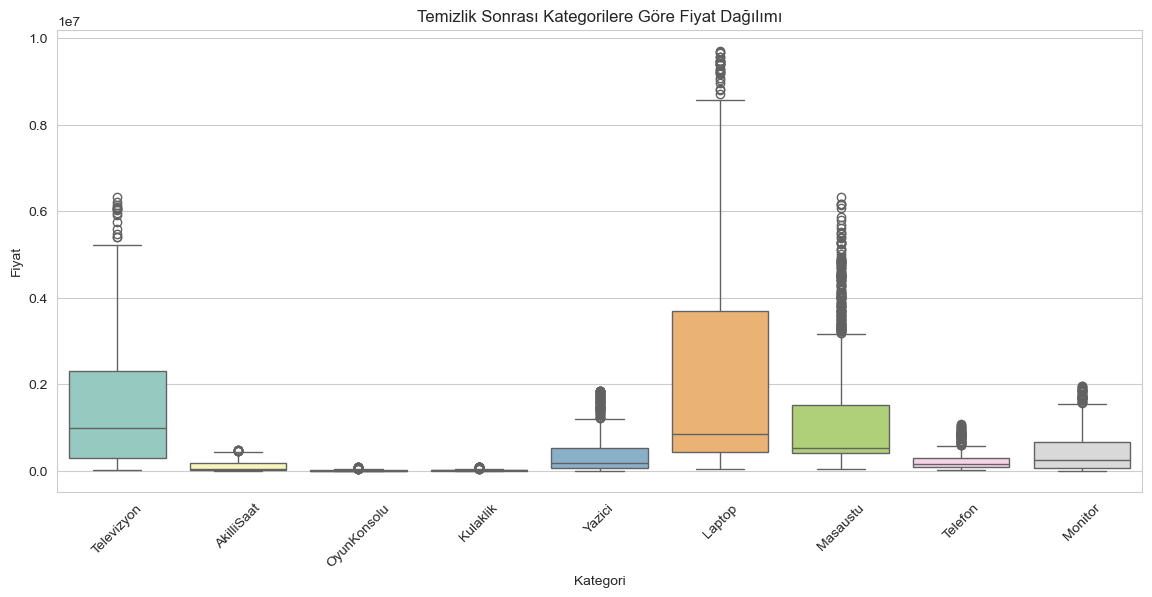

In [4]:
# --- Kategori Bazlı Aykırı Değer Temizliği ---
df_clean = pd.DataFrame()

for kategori in df['Kategori'].unique():
    cat_df = df[df['Kategori'] == kategori]
    
    # IQR Hesapla
    Q1 = cat_df['Fiyat'].quantile(0.25)
    Q3 = cat_df['Fiyat'].quantile(0.75)
    IQR = Q3 - Q1
    
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    
    # Sınırların dışındakileri at
    filtered_df = cat_df[(cat_df['Fiyat'] >= alt_sinir) & (cat_df['Fiyat'] <= ust_sinir)]
    
    df_clean = pd.concat([df_clean, filtered_df])
    
    print(f"📂 {kategori}: {len(cat_df)} -> {len(filtered_df)} ürün kaldı. (Üst Sınır: {int(ust_sinir)} TL)")

print("\n" + "="*30)
print(f"✅ TOPLAM TEMİZ VERİ: {len(df_clean)}")
print("="*30)

# Kutu Grafiği ile Son Durum
plt.figure(figsize=(14, 6))
sns.boxplot(x='Kategori', y='Fiyat', data=df_clean, palette="Set3")
plt.title("Temizlik Sonrası Kategorilere Göre Fiyat Dağılımı")
plt.xticks(rotation=45)
plt.show()

"Fiyat değişkenindeki aşırı uç değerler (Outliers), IQR yöntemi kullanılarak tespit edilmiş ve veri setinden çıkarılmıştır. Bu işlem, modelin genel geçerliliğini artırmak ve aşırı öğrenmeyi (Overfitting) engellemek için yapılmıştır."

ADIM 4: Detaylı Görselleştirme (EDA)

/var/folders/x4/79sm3j81269dw8tmh4g9579w0000gn/T/ipykernel_25026/2196222578.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Kategori', y='Fiyat', data=df_clean, estimator=np.mean, palette='viridis', errorbar=None)


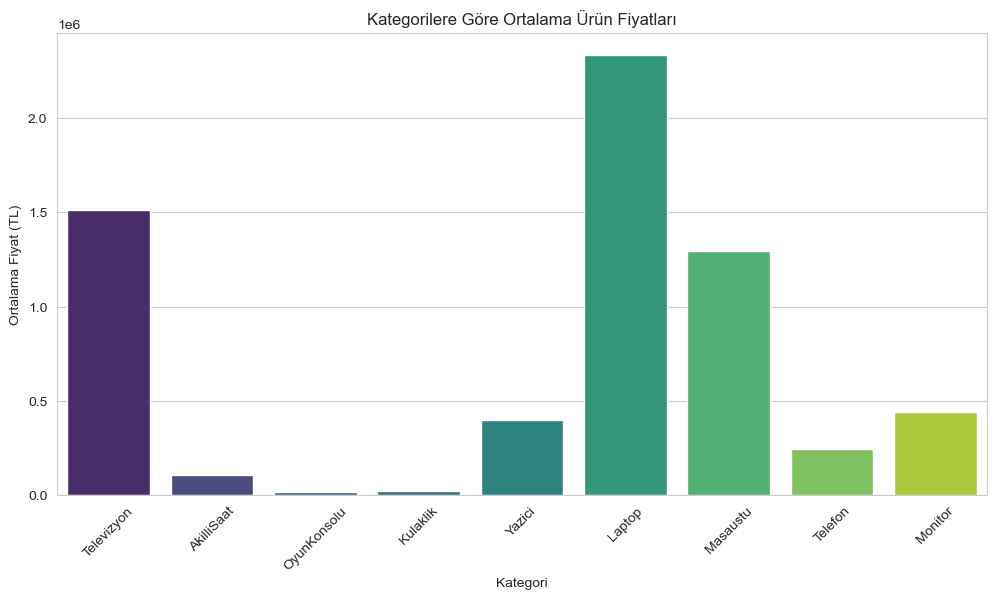

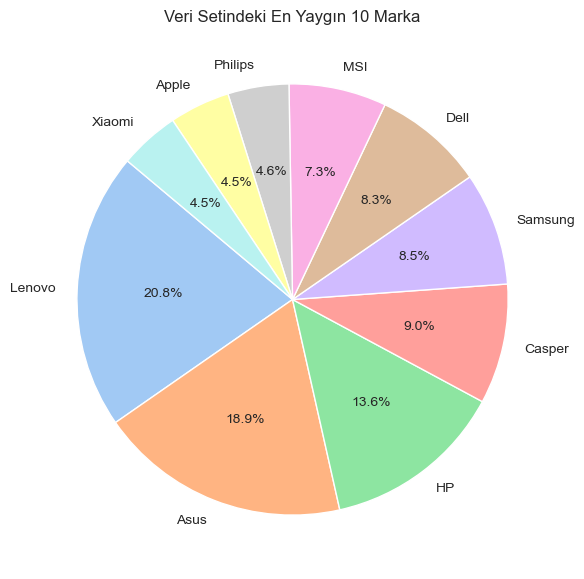

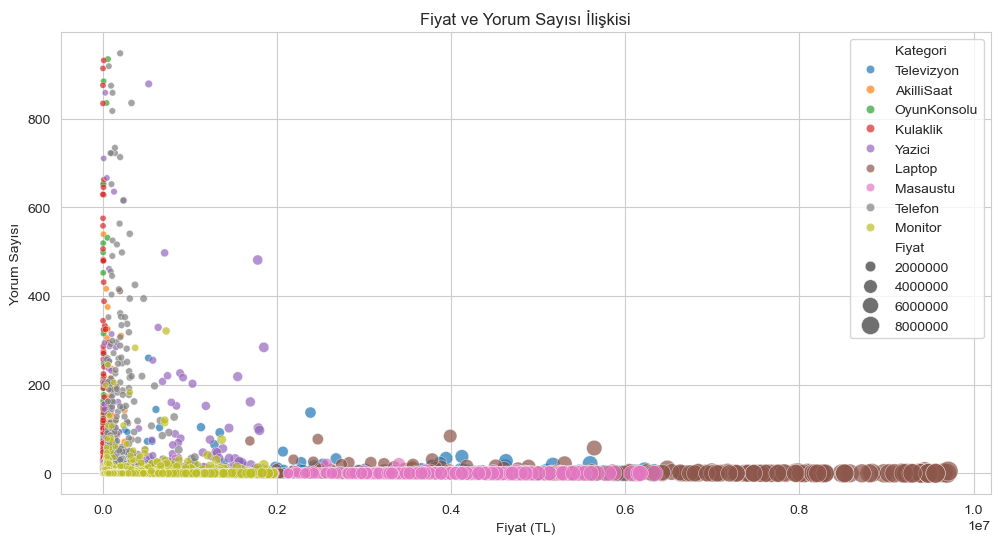

In [5]:
# 1. Kategorilere Göre Ortalama Fiyat
plt.figure(figsize=(12, 6))
sns.barplot(x='Kategori', y='Fiyat', data=df_clean, estimator=np.mean, palette='viridis', errorbar=None)
plt.title("Kategorilere Göre Ortalama Ürün Fiyatları")
plt.xticks(rotation=45)
plt.ylabel("Ortalama Fiyat (TL)")
plt.show()

# 2. En Çok Ürünü Olan 10 Marka (Pasta Grafiği)
plt.figure(figsize=(7, 7))
top_brands = df_clean['Marka'].value_counts().head(10)
plt.pie(top_brands, labels=top_brands.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Veri Setindeki En Yaygın 10 Marka")
plt.show()

# 3. Fiyat ve Yorum Sayısı İlişkisi
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Fiyat', y='Yorum_Sayisi', data=df_clean, hue='Kategori', size='Fiyat', sizes=(20, 200), alpha=0.7)
plt.title("Fiyat ve Yorum Sayısı İlişkisi")
plt.xlabel("Fiyat (TL)")
plt.ylabel("Yorum Sayısı")
plt.show()

Temiz veri setini kaydetme. 

In [6]:
# Final Dosyayı Kaydet
df_clean.to_csv("cleaned_data.csv", index=False)
print("💾 'cleaned_data.csv' başarıyla oluşturuldu.")
print("🚀 Şimdi bu dosyayı GitHub'a gönderin!")

💾 'cleaned_data.csv' başarıyla oluşturuldu.
🚀 Şimdi bu dosyayı GitHub'a gönderin!
